# <center> PROCESAMIENTO DIGITAL DE SEÑALES DE AUDIO</center>
## <center> Introducción al algoritmo de Phase Vocoder</center>      

In [1]:
%matplotlib inline

import math
import time
import numpy as np
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile

import IPython.display as ipd

**NOTA:** *Las siguientes dos celdas solo son necesarias para descargar el archivo de ejemplo. Ignórelas si va a trabajar con sus propios archivos de audio.*

In [2]:
import wget

### Cómo correr el notebook
Se puede bajar y correr el notebook de forma local en una computadora.

O también se puede correr en Google Colab usando el siguiente enlace. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/audio-dsp/blob/main/notebooks/audioDSP-intro_phase_vocoder.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

### Introducción

Este ejercicio sirve de introducción al algoritmo de phase vocoder. Se analiza una señal de audio usando la STFT y luego se la reconstruye antitransformando la DFT de cada trama y combinándolas mediante el método de Overlap-Add.

A continuación se carga la señal de audio que será procesada.

In [3]:
# download audio file
wget.download('https://github.com/mrocamora/audio-dsp/blob/main/audio/singing_voice.wav?raw=true')

100% [........................................................] 214914 / 214914

'singing_voice (1).wav'

In [4]:
# read the audio file to process (from https://openairlib.net/)
filename = 'singing_voice.wav'
# filename = './audio/trumpet.wav'

# read audio file
fs, x = wavfile.read(filename)

# normalize maximum (absolute) amplitude
x = x / np.max(abs(x)) * 0.9

Text(0, 0.5, 'Amplitude')

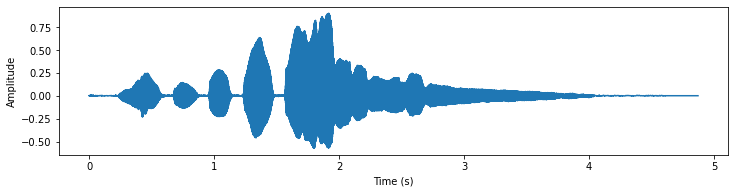

In [5]:
# time corresponding to the audio signal
time_x = np.arange(0, x.size)/fs

# plot the audio signal waveform
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(time_x, x)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [6]:
ipd.Audio(x, rate=fs)

### Parte 1

En esta primera parte se analiza el efecto del enventanado y las restricciones que debe cumplir según el método de **overlap-add**. 

Complete el código que se proporciona a continuación y siga los siguientes pasos. 

1. Acumular adecuadamente las ventanas de análisis de acuerdo al algoritmo de **overlap-add**.
2. Calcular el factor de escalado de amplitud $C$, para el caso en que el solapamiento de las ventanas es constante.
3. Cambiar el factor de decimación temporal ($R$) y analice los resultados. En particular pruebe para $\frac{1}{4} L$ y $\frac{3}{4} L$.
4. Analice el resultado para otras ventanas suavizantes (e.g. Hamming, Blackman) usando los mismos factores de decimación.


C =  1.0
max(olawin) =  1.0000000000000004


Text(0.5, 1.0, 'Overlap-add of the analysis windows')

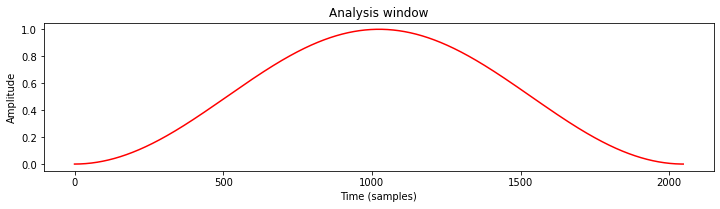

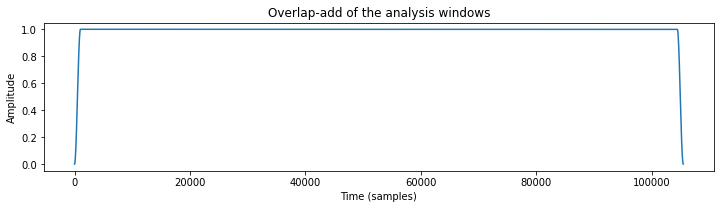

In [7]:
# length of the input signal
M = x.size;

# length of the analysis window in samples
L = 2048

# hop size in samples.
R = int(L/2)

# total number of analysis frames
num_frames = int(np.floor((M-L)/R))

# analysis window
window = signal.windows.get_window('hann', L)

# overlap-add (OLA) of the analysis windows
olawin = np.zeros((num_frames-1)*R+L)

# for each analysis frame
for ind in range(num_frames):
    
    # initial index of current window
    n_ini = ind * R
    
    # overlap-add the window
    olawin[n_ini:n_ini+L] += window

# compute the amplitude scaling factor
C = np.sum(window)/R #?


print("C = ", C)
print("max(olawin) = ", max(olawin))

# plot the analysis window
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(window, 'r')
plt.ylabel('Amplitude')
plt.xlabel('Time (samples)')
plt.title('Analysis window')

# plot the overlap-add of the analysis windows
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(olawin)
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.title('Overlap-add of the analysis windows')


### Parte 2

El siguiente código implementa la etapa de análisis del algoritmo de **phase-vocoder**, es decir una STFT. 

Complete el código que se proporciona a continuación y siguiendo los siguientes pasos. 

1. Calcular la DFT de cada trama de señal aplicando una ventana suavizante.
2. Calcular el valor de frequencia de cada bin en radianes.
3. Calcular el instante temporal en muestras de cada trama.


In [8]:
from scipy.fft import fft

In [9]:
def analysis_STFT(x, L=2048, R=256, win='hann'):
    """ compute the analysis phase of the phase vocoder, i.e. the STFT of the input audio signal
    
    Parameters
    ----------
    x : numpy array
        input audio signal (mono) as a numpy 1D array.
    L : int
        window length in samples.
    R : int
        hop size in samples.
    win : string
          window type as defined in scipy.signal.windows.    
        
    Returns
    -------
    X_stft : numpy array
             STFT of x as a numpy 2D array.
    omega_stft : numpy array
                 frequency values in radians.
    samps_stft : numpy array
                 time sample at the begining of each frame.

    """
    
    # length of the input signal
    M = x.size;      
    
    # number of points to compute the DFT (FFT)
    N = L
    
    # analysis window
    window = signal.windows.get_window(win, L)
   
    # total number of analysis frames
    num_frames = int(np.floor((M - L) / R))

    # initialize stft
    X_stft = np.zeros((N, num_frames), dtype = complex)
    
    # process each frame
    for ind in range(num_frames):

        # initial and ending points of the frame
        n_ini = int(ind * R)
        n_end = n_ini + L

        # signal frame
        xr = x[n_ini:n_end] * window

        # save DFT of the signal frame
        X_stft[:, ind] = fft(xr)
        
    # frequency values in radians    
    omega_stft = np.linspace(0, 2*np.pi, N)

    # time sample at the center of each frame
    samps_stft = np.arange(num_frames)*R + L/2
 
    return X_stft, omega_stft, samps_stft

### Parte 3

Una vez completada la implementación de la función `analysis_STFT` siga los siguientes pasos.

1. Ejecute la función `analysis_STFT` para distintos valores de $L$ y $R$ y analice el resultado en el espectragrama.
2. ¿Qué controla el parámetro $L$? ¿Qué controla el parámetro $R$? 
3. ¿Qué relación deben cumplir $L$ y $R$? ¿Por qué?

Text(0.5, 0, 'Time [sec]')

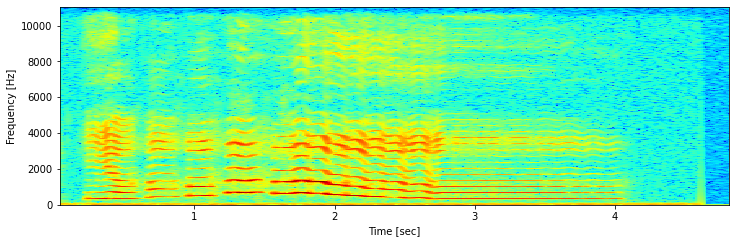

In [10]:
# window length in samples
L = 2048
# hop size in samples
R = 256

# compute STFT
X_stft, omega_stft, samps_stft = analysis_STFT(x, L, R, win='hann')

# max frequency index
ind_fmax = int(X_stft.shape[0]/2)+1
# frequency values (Hz)
stft_freqs = omega_stft[:ind_fmax]*fs/(2*np.pi)
# time values of the stft
stft_time = samps_stft/fs

plt.figure(figsize=(12,8))
ax1 = plt.subplot(2, 1, 1)
plt.pcolormesh(stft_time, stft_freqs, 20*np.log10(np.abs(X_stft[:ind_fmax, :])), cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')


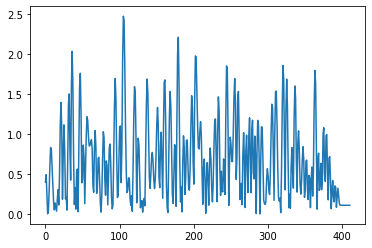

In [11]:
plt.plot(abs(X_stft[0]))

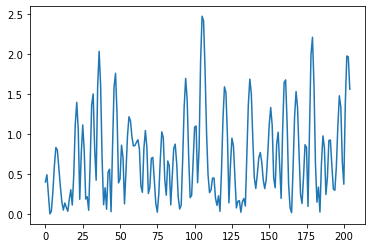

In [12]:
plt.plot(abs(X_stft[0][:X_stft[0].shape[0]//2]))

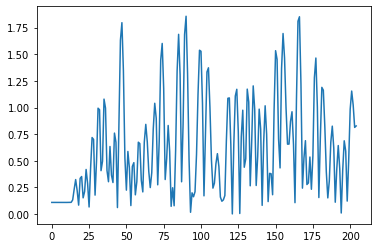

In [13]:
plt.plot(abs(X_stft[0][X_stft[0].shape[0]:X_stft[0].shape[0]//2: -1]))

### Parte 4

El siguiente código implementa la etapa de síntesis a partir de la STFT. 

Complete el código que se proporciona a continuación y siguiendo los siguientes pasos. 

1. Calcule la reconstrucción de cada trama de señal.
2. Acumule tramas sucesivas según el método de **overlap-adds**.
3. Modifique la amplitud de la señal obtenida por el factor de compensación del enventanado.


In [31]:
def synthesis_STFT(X_stft, L=2048, R=256, win='hann'):
    """ compute the synthesis using the IFFT of each frame combined with overlap-add
    
    Parameters
    ----------
    X_stft : numpy array
             STFT of x as a numpy 2D array.
    L : int
        window length in samples.
    R : int
        hop size in samples.
    win : string
          window type as defined in scipy.signal.windows.    
        
    Returns
    -------
    x : numpy array
        output audio signal (mono) as a numpy 1D array.
        
    """
    
    # number of frequency bins
    N = X_stft.shape[0];      
 
    # analysis window
    window = signal.windows.get_window(win, L)
   
    # total number of analysis frames
    num_frames = X_stft.shape[1]

    # initialize otuput signal in the time domain
    y = np.zeros(num_frames * R + L)
    
    # process each frame
    for ind in range(num_frames):
        # reconstructed signal frame
        yr = np.fft.ifft(X_stft[:,ind], n=L).real

        # initial and ending points of the frame
        n_ini = int(ind*R)
        n_end = n_ini + L
        # overlap-add the signal frame
        y[n_ini:n_end] += yr
        
    # compute the amplitude scaling factor
    C = np.sum(window)
    
    # compensate the amplitude scaling factor
    y /= C
    
    return y

### Parte 5

Una vez completada la implementación de la función `synthesis_STFT` siga los siguientes pasos.

1. Ejecute la función `analysis_STFT` y luego la función `synthesis_STFT` usando $L=2048$ y $R=256$. 
2. Evalúe la reconstrucción en términos de la forma de onda. Evalúe la reconstrucción auditivamente.
3. Ejecute la función `analysis_STFT` usando $L=2048$ y $R=256$. Ejecute la función `synthesis_STFT` usando $L=2048$ y $R=512$. 
4. Antes de escuchar el resultado indique qué tipo de modificación temporal espera que se produzca. ¿Una acortamiento o alargamiento temporal?
5. Evalúe la reconstrucción en términos de la forma de onda. Evalúe la reconstrucción auditivamente.
6. Repita la parte 3 en adelante usando $L=2048$ y $R=128$.

In [32]:
# window length in samples
L = 2048
# hop size in samples
R = 256

# compute STFT
X_stft, omega_stft, samps_stft = analysis_STFT(x, L, R, win='hann')

# hop size in samples
R = 256

# compute the synthesis from the STFT
y = synthesis_STFT(X_stft, L, R, win='hann')

Text(0, 0.5, 'Amplitude')

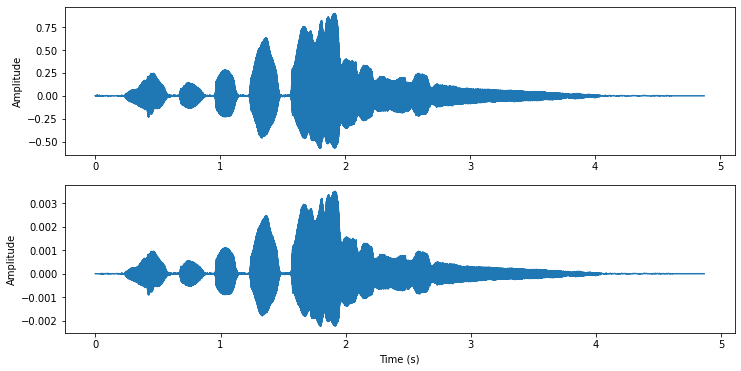

In [33]:
# time corresponding to the audio signal
time_y = np.arange(0, y.size)/fs

# plot the audio signal waveform
plt.figure(figsize=(12,6))
ax1 = plt.subplot(2, 1, 1)
plt.plot(time_x, x)
plt.ylabel('Amplitude')
ax1 = plt.subplot(2, 1, 2)
plt.plot(time_y, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

In [29]:
ipd.Audio(x, rate=fs)

In [34]:
ipd.Audio(y, rate=fs)